In [1]:
from types import SimpleNamespace
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pdb import set_trace

import torch
from torch import nn, optim
from torch.nn import functional as F
from dataset import get_data
from training import trainer
from testing import tester

import keras
from keras import layers, models
print(keras.backend.backend())
print(keras.backend.image_data_format())

torch
channels_first


### Configuration

In [2]:
args = SimpleNamespace(dataset="cifar10")
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.num_class = 10
args.batch = 32
args.lr = 5e-4
args.epoch = 100
print(args)

namespace(dataset='cifar10', device='cuda', num_class=10, batch=32, lr=0.0005, epoch=100)


In [3]:
loader = get_data(args.dataset, args.batch)
len(loader.train), len(loader.test)

Files already downloaded and verified
Files already downloaded and verified


(1562, 313)

In [4]:
x, y = next(iter(loader.train))
x.shape, y.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [5]:
input_layer = layers.Input((3, 32, 32))
x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(input_layer)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x)

output_layer = layers.Dense(args.num_class)(x)

keras_model = models.Model(input_layer, output_layer).to(args.device)
keras_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 32, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 16, 16)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 16, 16)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 8, 8)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 8, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,074 (2.26 MB)

 Trainable params: 591,674 (2.26 MB)

 Non-trainable params: 400 (1.56 KB)

In [6]:
x, y = next(iter(loader.train))
x.shape, y.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [7]:
pred_y = keras_model(x.to(args.device))
pred_y.shape

torch.Size([32, 10])

In [8]:
optimizer = optim.Adam(keras_model.parameters(), lr=args.lr)
loss_fn = nn.CrossEntropyLoss()

In [9]:
keras_model, train_loss = trainer(keras_model, loader.train, args.epoch, 
                                  optimizer, loss_fn, args.device)
keras_model.training

100%|██████████| 100/100 [42:32<00:00, 25.52s/it]


False

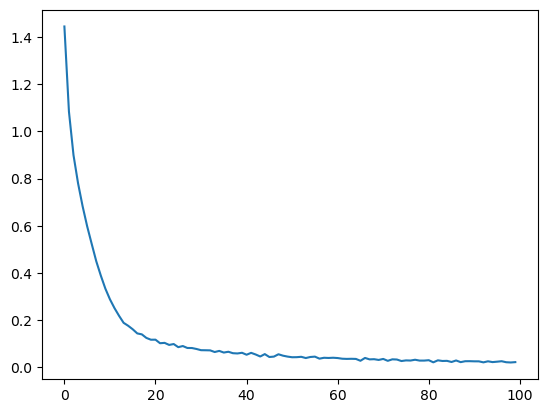

In [10]:
plt.plot(train_loss)
plt.show()

In [11]:
labels, preds = tester(keras_model, loader.test, args.device, predict=False)
acc = accuracy_score(labels, preds)
print("Test accuracy: ", round(100*acc, 2))

Test accuracy:  69.99


In [12]:
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = keras.Sequential([
            layers.Input((3, 32, 32)),
            layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same"),
            layers.BatchNormalization(),layers.LeakyReLU(),
            layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),layers.LeakyReLU(),
            layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same"),
            layers.BatchNormalization(),layers.LeakyReLU(),
            layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same"),
            layers.BatchNormalization(),layers.LeakyReLU(),
            layers.Flatten(),layers.Dense(128),layers.BatchNormalization(),
            layers.LeakyReLU(),layers.Dropout(rate=0.5),
            layers.Dense(num_classes)])

    def forward(self, x):
        return self.model(x)
    
    @torch.no_grad()
    def predict(self, x):
        x = self.forward(x)
        pred_y = F.softmax(x, dim=1)
        pred_class = torch.argmax(pred_y, dim=1)
        return pred_class.cpu()

In [13]:
torch_model = MyModel()
x, y = next(iter(loader.train))
x.shape, y.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [14]:
pred_y = torch_model(x)
pred_y.shape

torch.Size([32, 10])

In [15]:
torch_model = MyModel().to(args.device)
optimizer = optim.Adam(torch_model.parameters(), lr=args.lr)
loss_fn = nn.CrossEntropyLoss()

In [16]:
torch_model, train_loss = trainer(torch_model, loader.train, args.epoch, 
                                  optimizer, loss_fn, args.device)
torch_model.training

100%|██████████| 100/100 [42:49<00:00, 25.69s/it]


False

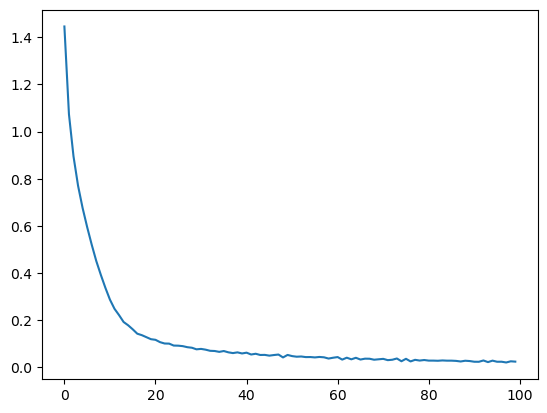

In [17]:
plt.plot(train_loss)
plt.show()

In [18]:
labels, preds = tester(torch_model, loader.test, args.device)
acc = accuracy_score(labels, preds)
print("Test accuracy: ", round(100*acc, 2))

Test accuracy:  70.22
